In [1]:
import pandas as pd
import json
import os
import glob
import numpy as np
from tensorflow import data as tf_data
import keras
from keras import layers
from matplotlib import pyplot as plt
import zipfile
from PIL import Image
import seaborn as sns
import io
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, accuracy_score

keras.utils.set_random_seed(seed=42)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/Shareddrives/TUG dataset/Pointnet_new.zip'

# Dictionary to store pixel arrays
pixel_arrays = {}

# Dictionary to store JSON file names
json_files = {}

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # List contents of the zip file
    zip_contents = zip_ref.namelist()

    # Iterate over zip contents
    for file_path in zip_contents:
        # If the file is a PNG image
        if 'data_GEI/Videos/' in file_path and file_path.endswith('.png'):
            # Extract file name
            file_name = file_path.split('/')[-2]
            file_name = file_name.replace(".mp4", "")

            # Open the PNG file from the zip file
            with zip_ref.open(file_path) as img_data:
                # Read the image data
                img = Image.open(io.BytesIO(img_data.read()))
                # Convert image to grayscale
                img = img.convert('L')
                img = img.resize((300,600))#resize to regular

                # Store pixel array in dictionary
                pixel_arrays[file_name] = img
        # If the file is a JSON file
        elif 'data_keypoints/Videos/' in file_path and file_path.endswith('.json'):
            # Extract folder name containing the JSON file
            folder_name = file_path.split('/')[-2]
            folder_name = folder_name.replace(".mp4", "")

            # Read the JSON file
            with zip_ref.open(file_path) as json_data:
                # Parse the JSON content
                json_content = json.load(json_data)

                # Initialize list to store keypoints
                keypoints_list = []

                # Iterate over each item in json_content
                for item in json_content:
                    # Extract keypoints from the item
                    keypoints = item.get('keypoints')
                    if keypoints:
                        # Add XYZ coordinates every three elements
                        xyz_coordinates = [keypoints[i:i+3] for i in range(0, len(keypoints), 3)]
                        # Append XYZ coordinates to the keypoints list
                        keypoints_list.extend(xyz_coordinates)

                # Store keypoints in dictionary
                if folder_name not in json_files:
                    json_files[folder_name] = keypoints_list
                else:
                    json_files[folder_name].extend(keypoints_list)


# # Display keypoints for each folder
# for folder_name, keypoints_list in json_files.items():
#     print(f"Folder: {folder_name}")
#     for i, keypoints in enumerate(keypoints_list):
#         print(f"JSON File {i+1} keypoints:")
#         print(keypoints)

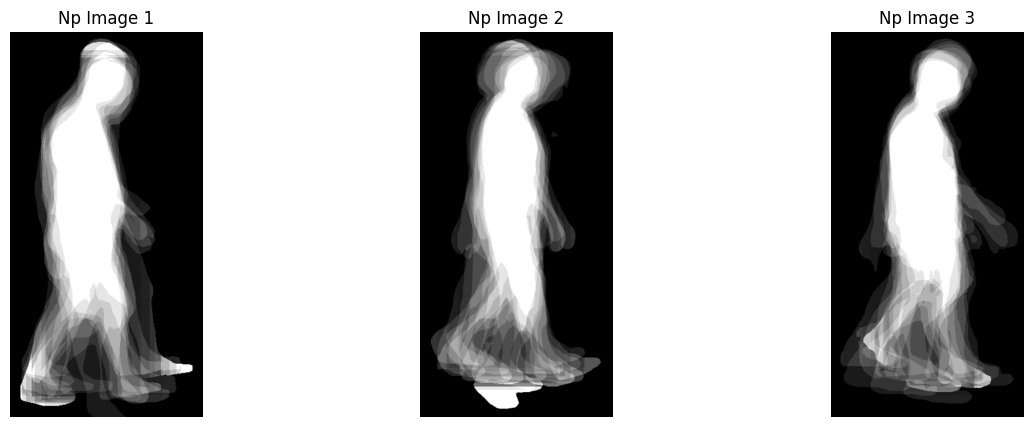

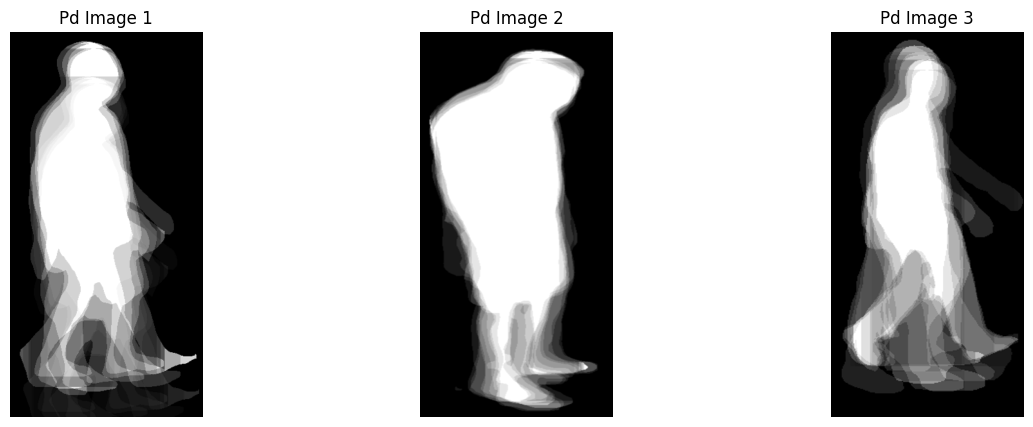

In [3]:
import random
# Define the keywords
keywords = ['NP', 'PD']

# Define the number of images to plot for each keyword
num_images_per_keyword = 3

# Plot images for each keyword
for keyword in keywords:
    # Filter pixel arrays by keyword
    keyword_pixel_arrays = {file_name: pixel_array for file_name, pixel_array in pixel_arrays.items() if keyword in file_name.upper()}

    # Select random images for the keyword
    images_to_plot = random.sample(list(keyword_pixel_arrays.values()), min(num_images_per_keyword, len(keyword_pixel_arrays)))

    # Plot the images
    plt.figure(figsize=(15, 5))
    for i, pixel_array in enumerate(images_to_plot):
        plt.subplot(1, num_images_per_keyword, i + 1)
        plt.imshow(pixel_array, cmap='gray')
        plt.title(f'{keyword.capitalize()} Image {i+1}')
        plt.axis('off')
    plt.show()

In [4]:
# Find the minimum length of keypoints lists
min_length = min(len(keypoints_list) for keypoints_list in json_files.values())

# Iterate over each folder in json_files
for folder_name, keypoints_list in json_files.items():
    # Resize the keypoints list to the minimum length
    json_files[folder_name] = keypoints_list[:min_length]

# Print the modified keypoints list lengths
for folder_name, keypoints_list in json_files.items():
    # Get the length of the keypoints list for the current folder
    keypoints_list_length = len(keypoints_list)
    # Print the folder name and the length of its keypoints list
    # print(f"{folder_name} Keypoints Length: {keypoints_list_length}")

In [5]:
# Initialize an empty list to store point clouds
point_clouds = []

# Iterate over pixel_arrays and json_files simultaneously
for file_name, pixel_array in pixel_arrays.items():
    if file_name in json_files:
        # Get keypoints for the current file_name
        keypoints_list = json_files[file_name]

        # Create a list to store XYZ coordinates for each item in keypoints_list
        point_cloud = []

        # Iterate over each item in keypoints_list
        for keypoints_array in keypoints_list:
            # Append the XYZ coordinates to the point_cloud list
            point_cloud.append(keypoints_array)

        # Append the point_cloud list to the list of point clouds
        point_clouds.append(point_cloud)

# Convert the list of point clouds into a NumPy array
point_clouds_array = np.array(point_clouds)

# Check the shape of the point clouds array
print("Shape of the point clouds array:", point_clouds_array.shape)

Shape of the point clouds array: (18, 6460, 3)


In [6]:
# Define the keywords for labeling
keywords = ['PD']

# Define the labels for each keyword
label_map = {keyword: 1 for keyword in keywords}
label_map['NP'] = 0

# Create y based on the keywords in the file names
y = []
for filename in pixel_arrays.keys():
    for keyword, label in label_map.items():
        if keyword in filename:
            y.append(label)
            break  # Stop searching for keywords once a match is found
    else:
        # If none of the keywords match, assign label 0 (normal)
        y.append(0)

# Convert y to a NumPy array
y = np.array(y)

# Print the resulting labels y
print("Labels y:")
print(y)

Labels y:
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


In [7]:
# Extract pixel arrays from the dictionary
pixel_arrays_list = [pixel_array for pixel_array in pixel_arrays.values()]

# Convert the list of pixel arrays into a NumPy array
pixel_arrays_np = np.array([np.array(img) for img in pixel_arrays_list])

# Reshape the pixel_arrays_np to flatten each image
pixel_arrays_flat = pixel_arrays_np.reshape(pixel_arrays_np.shape[0], -1)

print("Shape of pixel_arrays_flat:", pixel_arrays_flat.shape)

Shape of pixel_arrays_flat: (18, 180000)


# SVM

In [8]:
point_clouds_reshaped = point_clouds_array.reshape(point_clouds_array.shape[0], -1)

# Apply PCA to reduce the dimensionality of the feature sets
def apply_pca(X, n_components=8):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

X = pixel_arrays_flat
X2 = point_clouds_reshaped
X3 = np.hstack((pixel_arrays_flat,  point_clouds_reshaped))

# Apply PCA to the feature sets
X_pca = apply_pca(X)
X2_pca = apply_pca(X2)
X3_pca = apply_pca(X3)

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, log_loss


# Assuming pixel_arrays_pca and y have been defined
X_train_img, X_test_img, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, random_state=40
)

# Setup parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Create and fit GridSearchCV
grid_search = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=3, cv=4)
grid_search.fit(X_train_img, y_train)

# Output best parameters and CV score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Predict and evaluate using the best model
y_pred_img_best = grid_search.best_estimator_.predict(X_test_img)
accuracy_img_best = accuracy_score(y_test, y_pred_img_best)
print(f'Test accuracy using image data with PCA and best SVM: {accuracy_img_best:.4f}')

Fitting 4 folds for each of 32 candidates, totalling 128 fits
[CV 1/4] END ........C=0.1, gamma=1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 2/4] END ........C=0.1, gamma=1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 3/4] END ........C=0.1, gamma=1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 4/4] END ........C=0.1, gamma=1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 1/4] END .....C=0.1, gamma=1, kernel=linear;, score=0.333 total time=   0.0s
[CV 2/4] END .....C=0.1, gamma=1, kernel=linear;, score=0.667 total time=   0.0s
[CV 3/4] END .....C=0.1, gamma=1, kernel=linear;, score=0.667 total time=   0.0s
[CV 4/4] END .....C=0.1, gamma=1, kernel=linear;, score=1.000 total time=   0.0s
[CV 1/4] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 2/4] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 3/4] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 4/4] END ......C=0.1, gamma=0.1, kernel=rbf

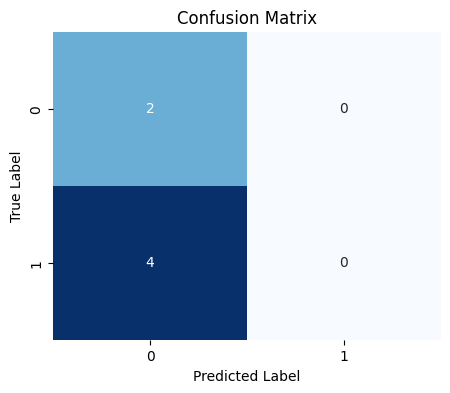

In [10]:
# Compute confusion matrix
conf_matrix_img = confusion_matrix(y_test, y_pred_img_best)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_img, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Classification Report
class_report = classification_report(y_test, y_pred_img_best)
print("Classification Report:")
print(class_report)

# Calculate AUC
y_prob_img_best = grid_search.best_estimator_.decision_function(X_test_img)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_img_best)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6

AUC: 0.5000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


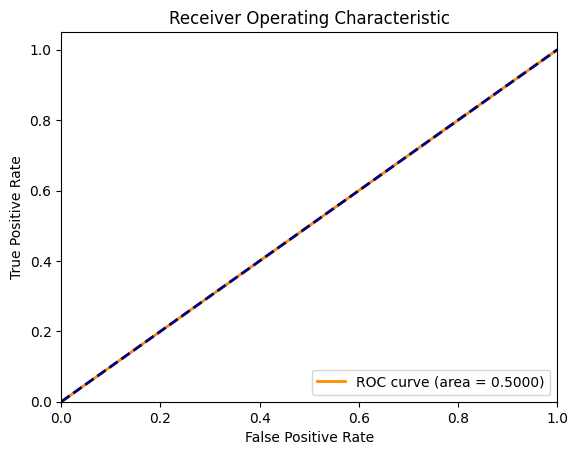

In [12]:
# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


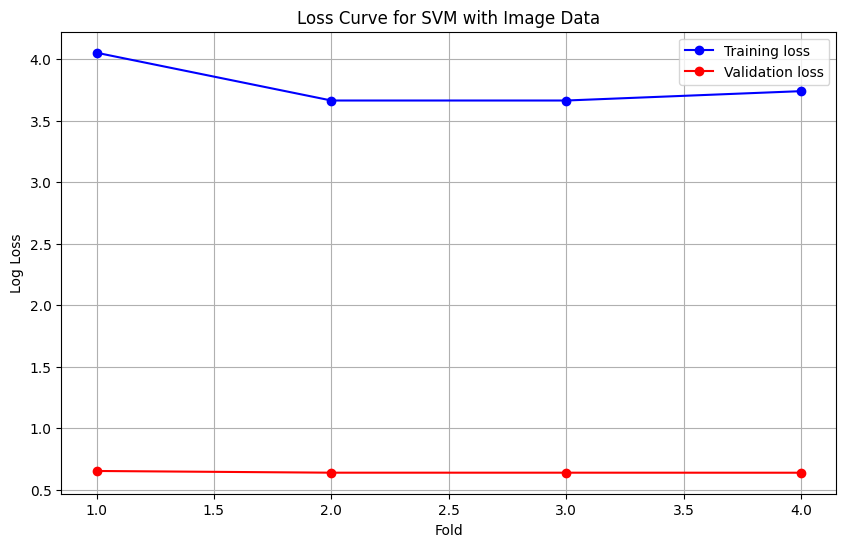

In [13]:
# Get the best model
best_model = grid_search.best_estimator_

# Define a custom training loop to track loss using StratifiedKFold
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=40)
train_losses, val_losses = [], []

for train_index, val_index in skf.split(X_train_img, y_train):
    X_train_fold, X_val_fold = X_train_img[train_index], X_train_img[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    best_model.fit(X_train_fold, y_train_fold)

    y_train_prob = best_model.predict_proba(X_train_fold)
    y_val_prob = best_model.predict_proba(X_val_fold)

    train_loss = log_loss(y_train_fold, y_train_prob)
    val_loss = log_loss(y_val_fold, y_val_prob)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'o-', color='blue', label='Training loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'o-', color='red', label='Validation loss')

# Plot settings
plt.title('Loss Curve for SVM with Image Data')
plt.xlabel('Fold')
plt.ylabel('Log Loss')
plt.legend(loc='best')
plt.grid()
plt.show()


In [14]:
# Cross-validation evaluation
cv_scores = cross_val_score(grid_search.best_estimator_, X_pca, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

Cross-validation scores: [0.5        0.5        0.5        0.66666667 0.66666667]
Mean cross-validation score: 0.5666666666666667


In [15]:
# Assuming data_reduced and y have been defined
X_train_pc, X_test_pc, y_train, y_test = train_test_split(
    X2_pca, y, test_size=0.3, random_state=40
)

# Setup parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']  # Including both RBF and linear kernels for comparison
}

# Create a GridSearchCV object
grid_search_json = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=3, cv=4)

# Fit GridSearchCV on the training data
grid_search_json.fit(X_train_pc, y_train)

# Print the best parameters and the best cross-validation score
print("Best parameters found:", grid_search_json.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search_json.best_score_))

# Predict using the best model
y_pred_json = grid_search_json.best_estimator_.predict(X_test_pc)

# Calculate the test accuracy
accuracy_json = accuracy_score(y_test, y_pred_json)
print(f'Test accuracy using JSON data with best SVM: {accuracy_json:.4f}')

Fitting 4 folds for each of 32 candidates, totalling 128 fits
[CV 1/4] END ........C=0.1, gamma=1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 2/4] END ........C=0.1, gamma=1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 3/4] END ........C=0.1, gamma=1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 4/4] END ........C=0.1, gamma=1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 1/4] END .....C=0.1, gamma=1, kernel=linear;, score=0.333 total time=   0.0s
[CV 2/4] END .....C=0.1, gamma=1, kernel=linear;, score=0.333 total time=   0.0s
[CV 3/4] END .....C=0.1, gamma=1, kernel=linear;, score=1.000 total time=   0.0s
[CV 4/4] END .....C=0.1, gamma=1, kernel=linear;, score=0.667 total time=   0.0s
[CV 1/4] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 2/4] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 3/4] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 4/4] END ......C=0.1, gamma=0.1, kernel=rbf

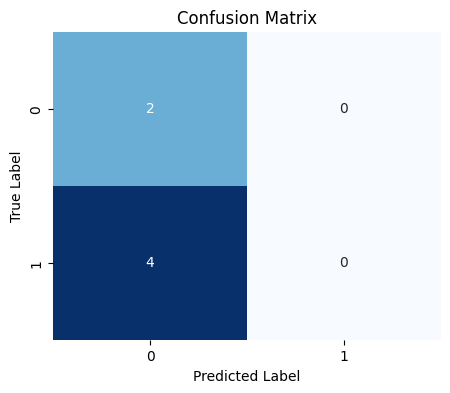

In [16]:
# Compute confusion matrix
conf_matrix_json = confusion_matrix(y_test, y_pred_json)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_json, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Classification Report
class_report_json = classification_report(y_test, y_pred_json)
print("Classification Report:")
print(class_report_json)

# Calculate AUC
y_prob_json = grid_search_json.best_estimator_.decision_function(X_test_pc)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_json)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         2
           1       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6

AUC: 0.5000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


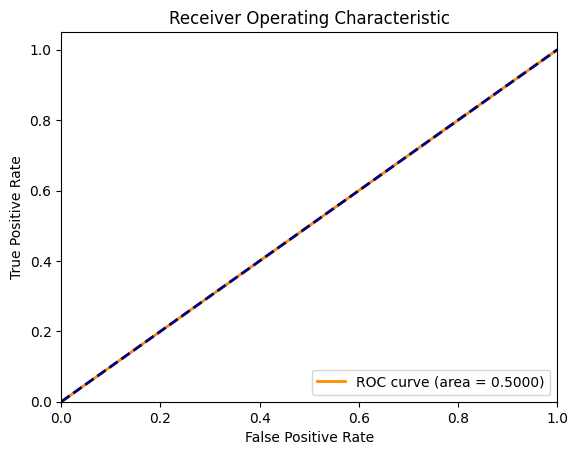

In [18]:
# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


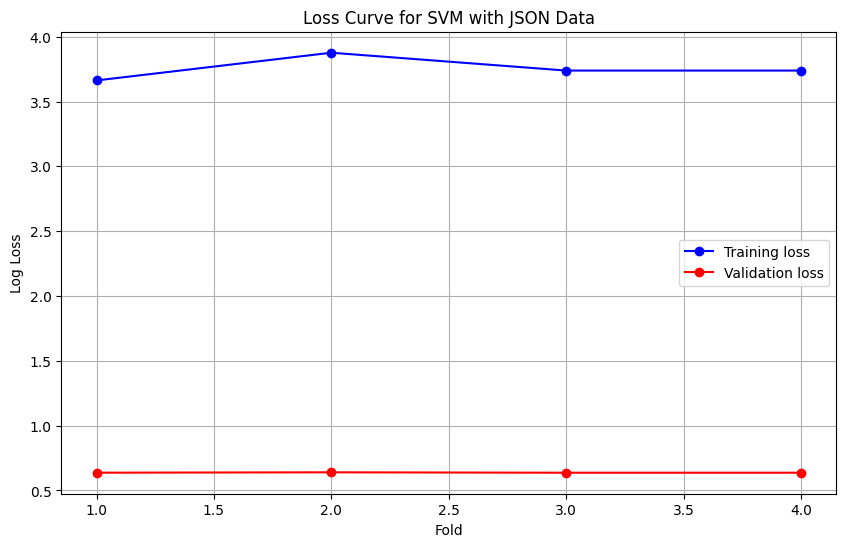

In [19]:
# Get the best model
best_model = grid_search_json.best_estimator_

# Define a custom training loop to track loss using StratifiedKFold
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=40)
train_losses, val_losses = [], []

for train_index, val_index in skf.split(X_train_pc, y_train):
    X_train_fold, X_val_fold = X_train_pc[train_index], X_train_pc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    best_model.fit(X_train_fold, y_train_fold)

    y_train_prob = best_model.predict_proba(X_train_fold)
    y_val_prob = best_model.predict_proba(X_val_fold)

    train_loss = log_loss(y_train_fold, y_train_prob)
    val_loss = log_loss(y_val_fold, y_val_prob)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'o-', color='blue', label='Training loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'o-', color='red', label='Validation loss')

# Plot settings
plt.title('Loss Curve for SVM with JSON Data')
plt.xlabel('Fold')
plt.ylabel('Log Loss')
plt.legend(loc='best')
plt.grid()
plt.show()

In [20]:
# Cross-validation evaluation
cv_scores = cross_val_score(grid_search_json.best_estimator_, X2_pca, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

Cross-validation scores: [0.5        0.5        0.5        0.66666667 0.66666667]
Mean cross-validation score: 0.5666666666666667


In [21]:
# Assuming combined_data and y have been defined
X_train_combined, X_test_combined, y_train, y_test = train_test_split(
    X3_pca, y, test_size=0.3, random_state=40
)

# Setup parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Create a GridSearchCV object
grid_search_combined = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=3, cv=5)

# Fit GridSearchCV on the training data
grid_search_combined.fit(X_train_combined, y_train)

# Print the best parameters and the best cross-validation score
print("Best parameters found:", grid_search_combined.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search_combined.best_score_))

# Predict using the best model
y_pred_combined = grid_search_combined.best_estimator_.predict(X_test_combined)

# Calculate the test accuracy
accuracy_combined = accuracy_score(y_test, y_pred_combined)
print(f'Test accuracy using combined data with best SVM: {accuracy_combined:.4f}')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=1.000 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.333 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.667 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=1.000 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.500 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=1.000 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[CV 5/5] END ...C=1, gamma=0.001, kernel=linear;, score=1.000 total time=   0.0s
[CV 1/5] END .........C=10, gamma=1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 2/5] END .........C=10, gamma=1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 3/5] END .........C=10, gamma=1, kernel=rbf;, score=1.000 total time=   0.0s
[CV 4/5] END .........C=10, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 5/5] END .........C=10, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 1/5] END ......C=10, gamma=1, kernel=linear;, score=0.333 total time=   0.0s
[CV 2/5] END ......C=10, gamma=1, kernel=linear;, score=0.667 total time=   0.0s
[CV 3/5] END ......C=10, gamma=1, kernel=linear;, score=1.000 total time=   0.0s
[CV 4/5] END ......C=10, gamma=1, kernel=linear;, score=0.500 total time=   0.0s
[CV 5/5] END ......C=10, gamma=1, kernel=linear;, score=1.000 total time=   0.0s
[CV 1/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.667 total time=   0.0s
[CV 2/5] END .......C=10, ga

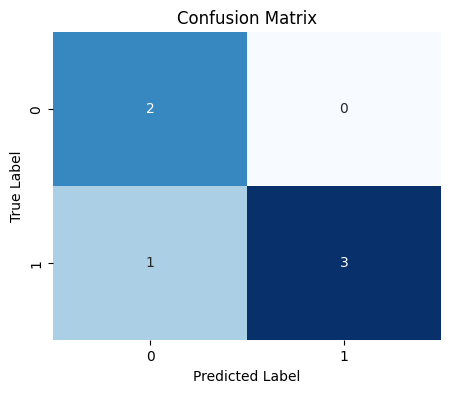

In [22]:
# Compute confusion matrix
conf_matrix_combined = confusion_matrix(y_test, y_pred_combined)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_combined, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
# Classification Report
class_report_combined = classification_report(y_test, y_pred_combined)
print("Classification Report:")
print(class_report_combined)

# Calculate AUC
y_prob_combined = grid_search_combined.best_estimator_.decision_function(X_test_combined)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_combined)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.75      0.86         4

    accuracy                           0.83         6
   macro avg       0.83      0.88      0.83         6
weighted avg       0.89      0.83      0.84         6

AUC: 0.8750


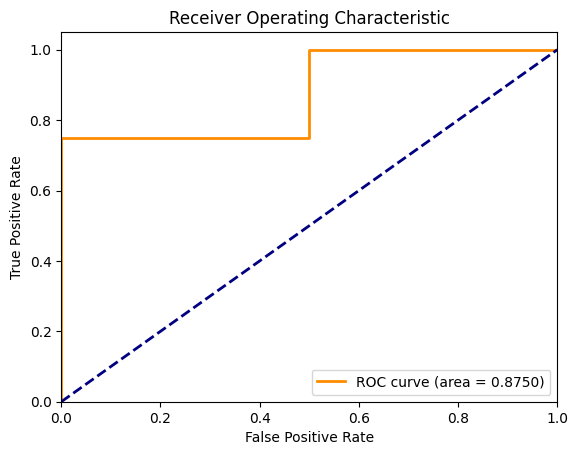

In [24]:
# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Skipping a fold due to only one class present in the fold.


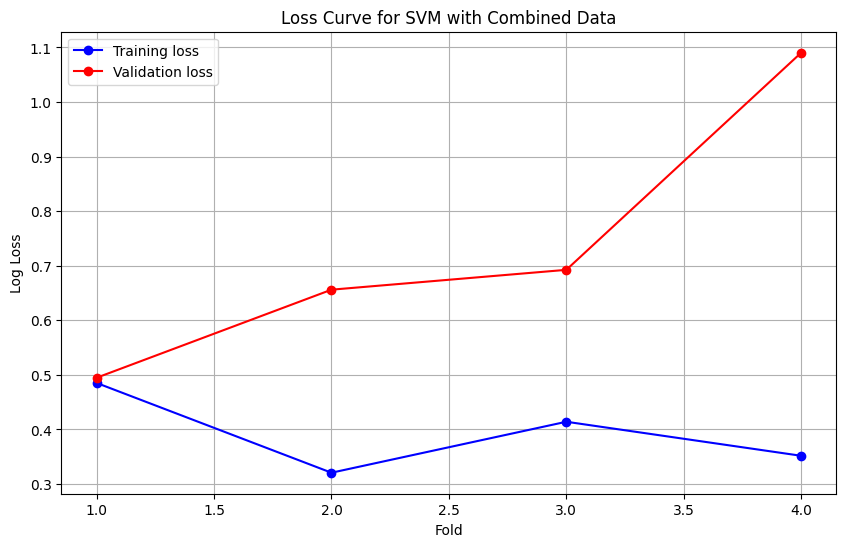

In [25]:
# Get the best model
best_model = grid_search_combined.best_estimator_

# Define a custom training loop to track loss using StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)
train_losses, val_losses = [], []

for train_index, val_index in skf.split(X_train_combined, y_train):
    X_train_fold, X_val_fold = X_train_combined[train_index], X_train_combined[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Check if both classes are present in the fold
    if len(np.unique(y_train_fold)) < 2 or len(np.unique(y_val_fold)) < 2:
        print("Skipping a fold due to only one class present in the fold.")
        continue

    best_model.fit(X_train_fold, y_train_fold)

    y_train_prob = best_model.predict_proba(X_train_fold)
    y_val_prob = best_model.predict_proba(X_val_fold)

    train_loss = log_loss(y_train_fold, y_train_prob)
    val_loss = log_loss(y_val_fold, y_val_prob)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'o-', color='blue', label='Training loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'o-', color='red', label='Validation loss')

# Plot settings
plt.title('Loss Curve for SVM with Combined Data')
plt.xlabel('Fold')
plt.ylabel('Log Loss')
plt.legend(loc='best')
plt.grid()
plt.show()

In [26]:
# Cross-validation evaluation
cv_scores = cross_val_score(grid_search_combined.best_estimator_, X3_pca, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", np.mean(cv_scores))

Cross-validation scores: [1.         0.5        1.         0.66666667 0.33333333]
Mean cross-validation score: 0.7


In [27]:
print(f'Test accuracy using image data with PCA and best SVM: {accuracy_img_best:.4f}')
print(f'Test accuracy using JSON data with best SVM: {accuracy_json:.4f}')
print(f'Test accuracy using combined data with best SVM: {accuracy_combined:.4f}')

Test accuracy using image data with PCA and best SVM: 0.3333
Test accuracy using JSON data with best SVM: 0.3333
Test accuracy using combined data with best SVM: 0.8333


In [33]:
# Define the keywords
keywords = ['NP', 'PD']

# Define the number of images to plot for each keyword
num_images_per_keyword = 3

# Function to plot GEI images
def plot_gei_images(pixel_arrays, keywords, num_images_per_keyword):
    for keyword in keywords:
        # Filter pixel arrays by keyword
        keyword_pixel_arrays = {file_name: pixel_array for file_name, pixel_array in pixel_arrays.items() if keyword in file_name.upper()}

        # Select random images for the keyword
        images_to_plot = random.sample(list(keyword_pixel_arrays.values()), min(num_images_per_keyword, len(keyword_pixel_arrays)))

        # Plot the images
        plt.figure(figsize=(15, 5))
        for i, pixel_array in enumerate(images_to_plot):
            plt.subplot(1, num_images_per_keyword, i + 1)
            plt.imshow(pixel_array, cmap='gray')
            plt.title(f'{keyword.capitalize()} Image {i+1}')
            plt.axis('off')

        plt.savefig(f'{keyword}_images.eps', format='eps')
        plt.show()


# Function to plot JSON keypoints
def plot_json_keypoints(json_files, keywords, num_samples_per_keyword):
    for keyword in keywords:
        # Filter json files by keyword
        keyword_json_files = {file_name: keypoints for file_name, keypoints in json_files.items() if keyword in file_name.upper()}

        # Select random keypoints for the keyword
        samples_to_plot = random.sample(list(keyword_json_files.items()), min(num_samples_per_keyword, len(keyword_json_files)))

        # Plot the keypoints
        fig = plt.figure(figsize=(20, 5))
        for i, (file_name, keypoints) in enumerate(samples_to_plot):
            ax = fig.add_subplot(1, num_samples_per_keyword, i + 1, projection='3d')
            keypoints = np.array(keypoints)

            # Extract X, Y, Z coordinates
            x_coords = keypoints[:, 0]
            y_coords = keypoints[:, 1]
            z_coords = keypoints[:, 2]

            # Plot with different colors
            ax.scatter(x_coords, y_coords, z_coords, c='r', marker='o', label='X')
            ax.scatter(x_coords, y_coords, z_coords, c='g', marker='o', label='Y')
            ax.scatter(x_coords, y_coords, z_coords, c='b', marker='o', label='Z')

            ax.set_title(f'{keyword.capitalize()} Keypoints {i+1}')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.legend()

        plt.savefig("figurename.eps", format="eps",  bbox_inches="tight")
        plt.show()

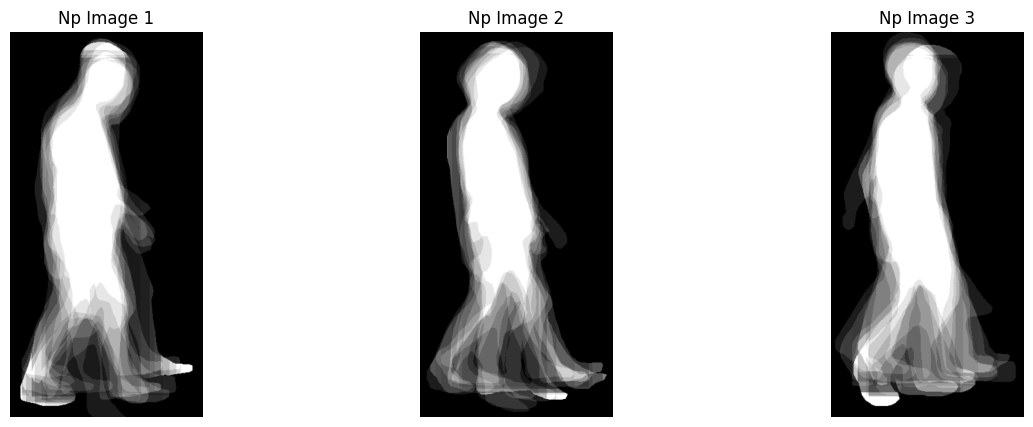

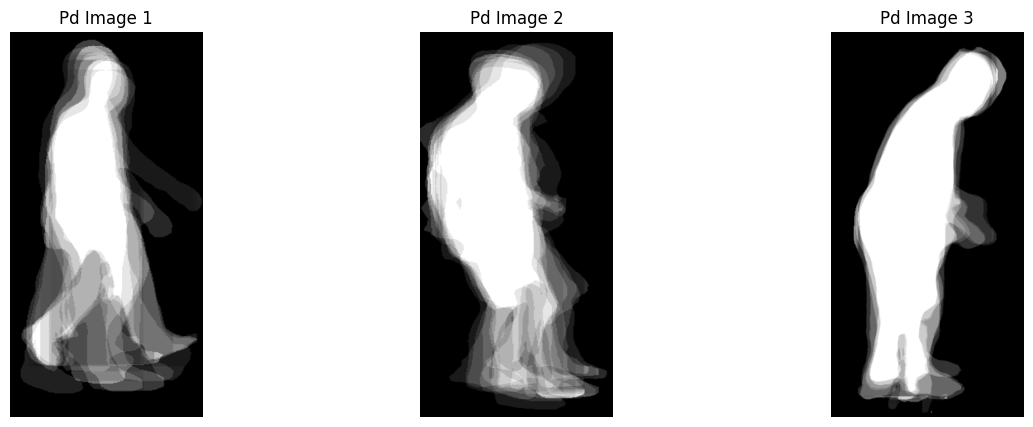

In [29]:
# Plot GEI images
plot_gei_images(pixel_arrays, keywords, num_images_per_keyword)

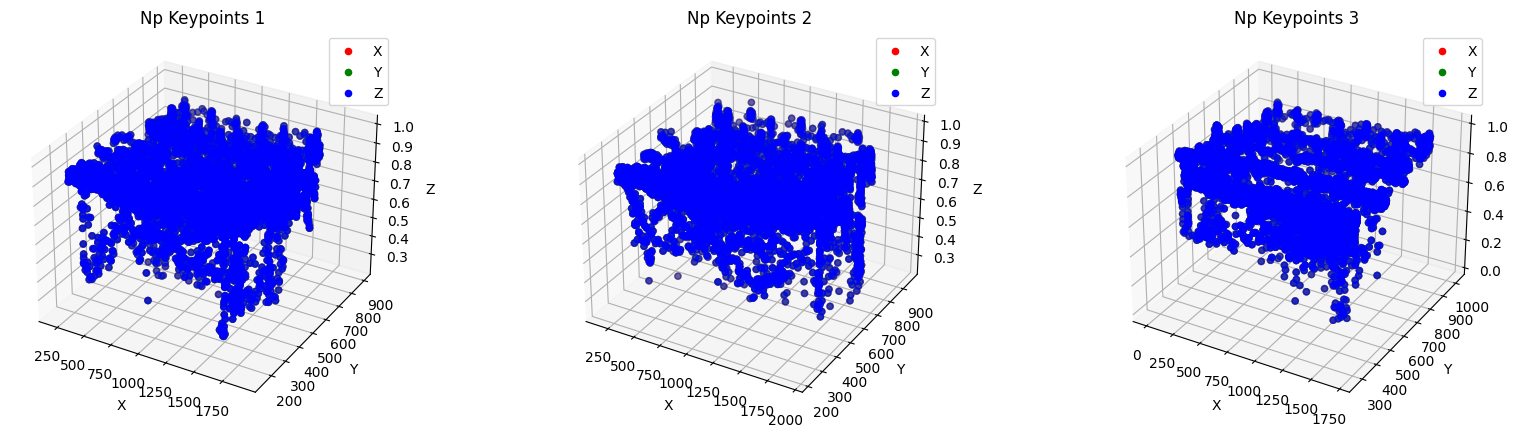

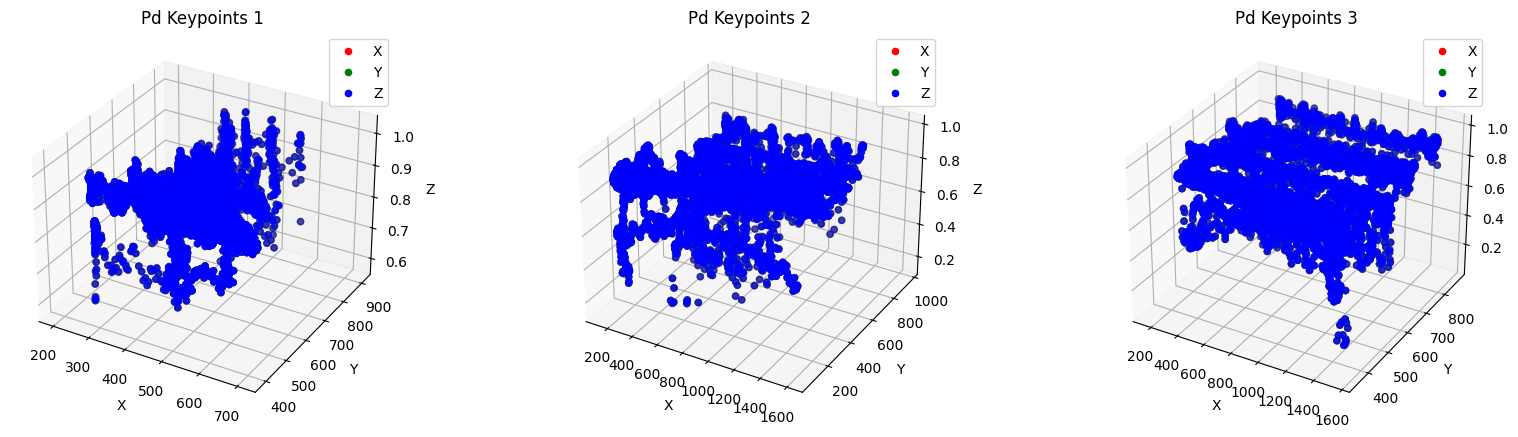

In [34]:
# Plot JSON keypoints
plot_json_keypoints(json_files, keywords, num_images_per_keyword)

In [31]:
import time, timeit
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files

def run_tabular_models(X_train, y_train, X_test, y_test):
    # Define the models to evaluate
    tabular_models = {
        'SVM': SVC(random_state=0),
        'RandomForest': RandomForestClassifier(random_state=0),
        'Logistic': LogisticRegression(random_state=0, n_jobs=-1, solver='newton-cg'),
        'KNN': KNeighborsClassifier(),
        'GaussianNB': GaussianNB(),
        'DecisionTree': DecisionTreeClassifier(random_state=0),
    }

    # DataFrame to store evaluation metrics for each model
    metrics_df = pd.DataFrame(columns=['model', 'runtime', 'AUC', 'precision', 'recall', 'f1-score'])

    # Evaluate each model
    for model in tabular_models.items():
        metrics = predict_eval(model, X_in=(X_train, X_test), y_in=(y_train, y_test))
        these_metrics = pd.DataFrame(data=metrics)
        metrics_df = pd.concat([metrics_df, these_metrics], ignore_index=True)

    # Save metrics to CSV
    metrics_df.to_csv('metrics.csv', index=False)
    files.download('metrics.csv')
    return metrics_df

def predict_eval(model, X_in=None, y_in=None):
    target_names = ['NP', 'PD']
    model_name, clf = model

    # Add StandardScaler to the pipeline
    clf = make_pipeline(StandardScaler(), clf)
    has_proba = hasattr(clf, 'predict_proba')

    if X_in is not None:
        X_train, X_test = X_in
        y_train, y_test = y_in

    # Fit the pipeline with the training data
    clf.fit(X_train, y_train)

    starttime = timeit.default_timer()

    # Make predictions
    y_pred = clf.predict(X_test)
    runtime = timeit.default_timer() - starttime

    # Calculate precision, recall, and f1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    # Calculate AUC if the classifier has a predict_proba method
    if has_proba:
        probs = clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, probs)
    else:
        print("Skipping AUC since chosen classifier has no predict_proba() method")
        auc = 0

    # Print classification report
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Display confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.grid(False)
    plt.show()

    # Return evaluation metrics
    return {
        'model': [model_name],
        'runtime': [runtime],
        'AUC': [auc],
        'precision': [precision],
        'recall': [recall],
        'f1-score': [f1]
    }

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

Skipping AUC since chosen classifier has no predict_proba() method
              precision    recall  f1-score   support

          NP       0.33      1.00      0.50         2
          PD       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6



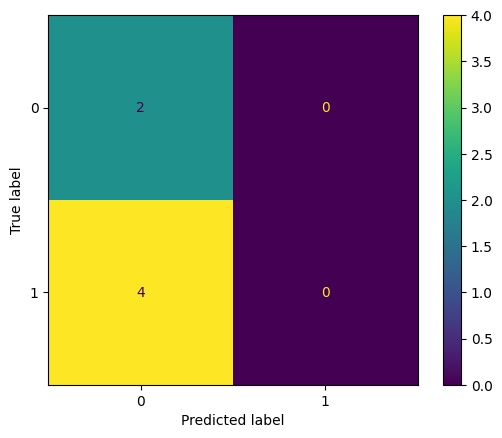

              precision    recall  f1-score   support

          NP       0.50      1.00      0.67         2
          PD       1.00      0.50      0.67         4

    accuracy                           0.67         6
   macro avg       0.75      0.75      0.67         6
weighted avg       0.83      0.67      0.67         6



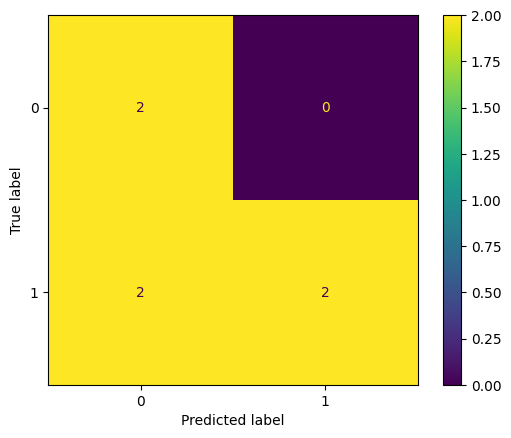

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


              precision    recall  f1-score   support

          NP       0.40      1.00      0.57         2
          PD       1.00      0.25      0.40         4

    accuracy                           0.50         6
   macro avg       0.70      0.62      0.49         6
weighted avg       0.80      0.50      0.46         6



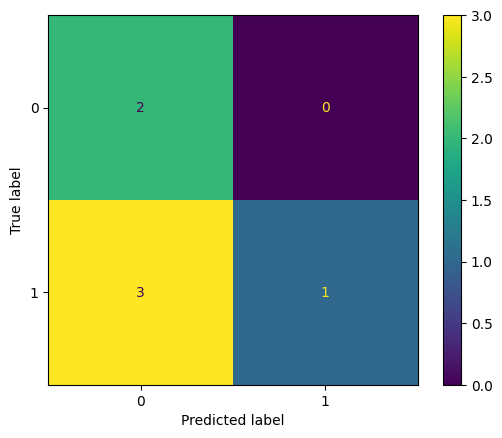

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

              precision    recall  f1-score   support

          NP       0.33      1.00      0.50         2
          PD       0.00      0.00      0.00         4

    accuracy                           0.33         6
   macro avg       0.17      0.50      0.25         6
weighted avg       0.11      0.33      0.17         6



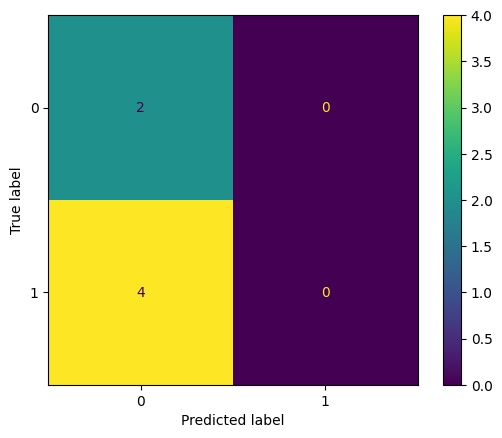

              precision    recall  f1-score   support

          NP       0.40      1.00      0.57         2
          PD       1.00      0.25      0.40         4

    accuracy                           0.50         6
   macro avg       0.70      0.62      0.49         6
weighted avg       0.80      0.50      0.46         6



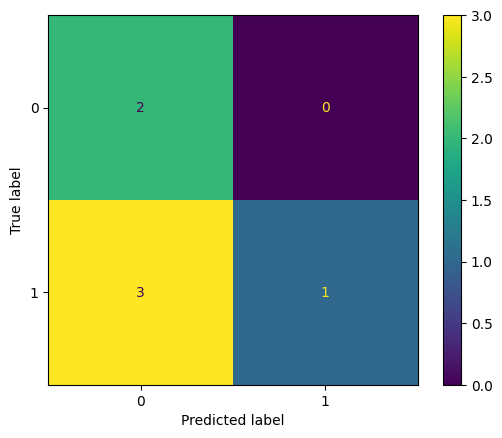

              precision    recall  f1-score   support

          NP       0.50      1.00      0.67         2
          PD       1.00      0.50      0.67         4

    accuracy                           0.67         6
   macro avg       0.75      0.75      0.67         6
weighted avg       0.83      0.67      0.67         6



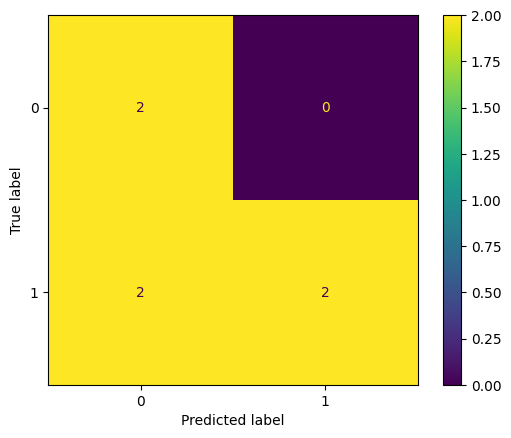

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,model,runtime,AUC,precision,recall,f1-score
0,SVM,0.000480,0,0.0,0.00,0.000000
1,RandomForest,0.007227,0.875,1.0,0.50,0.666667
2,Logistic,0.001078,0.625,1.0,0.25,0.400000
3,KNN,0.003290,0.8125,0.0,0.00,0.000000
4,GaussianNB,0.000451,0.625,1.0,0.25,0.400000
5,DecisionTree,0.000366,0.75,1.0,0.50,0.666667


In [32]:
# run_tabular_models(X_train_combined, y_train,X_test_combined, y_test)